# Part 4.2: Training and Optimization

In this notebook we will train and optimize our model. We will use XGBoost architecture and OPTUNA optimizer. A detailed comparison of different architectures and exhaustive hyperparameter optimization is left for future.

The dataset split is done such that:
- 2000-2015 is used for training,
- 2015-2017 is used for validation,
- 2018 is used for testing.

We also want to see how the model predicts the 2018 January flood. The outputs will be saved and results will be explored in the next notebook.



## Preprocess

In [1]:
# How many days in advance should the forecasting be made? (1,3,7 is supported with ECMWF comparison)
lead_day=1

save_dir = "/Users/oncel/Documents/Projects/KoelnPegelML/finalplots_"+str(lead_day)+"day"
# Include necessary tools
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
%matplotlib inline
import netCDF4 as nc
from matplotlib.dates import DateFormatter
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
debug=0

In [2]:
# Read-in information saved in notebook 4.1:

INF_str = "/Users/oncel/Documents/Projects/KoelnPegelML/training_datasets/"
df_ml = pd.read_csv(INF_str+"TRAIN"+str(lead_day)+".csv", index_col=0, parse_dates=True)
if debug==1: 
    print(df_ml.columns.tolist())

X_ready = pd.read_csv(INF_str+"Xready"+str(lead_day)+".csv", index_col=0, parse_dates=True)
y_ready = pd.read_csv(INF_str+"Yready"+str(lead_day)+".csv", index_col=0, parse_dates=True)
y = pd.read_csv(INF_str+"Y"+str(lead_day)+".csv", index_col=0, parse_dates=True)
import joblib

# Load from files
scaler = joblib.load("scaler_X"+str(lead_day)+".pkl")
scaler_y = joblib.load("scaler_y"+str(lead_day)+".pkl")

# Training

In [3]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# --- Split by date ---
train_end   = "2015-12-31"
valid_end   = "2017-12-31"
test_end    = "2018-12-31"

X_train, y_train = X_ready.loc[:train_end], y_ready.loc[:train_end]
X_valid, y_valid = X_ready.loc[train_end:valid_end], y_ready.loc[train_end:valid_end]
X_test,  y_test  = X_ready.loc[valid_end:test_end], y_ready.loc[valid_end:test_end]

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


# --- Define Optuna objective (optimize for q=0.5, median) ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 20),
        "random_state": 42,
        "min_child_weight": trial.suggest_int("min_child_weight", 0.5, 10),
        "eval_metric": "rmse",  
        "n_jobs": -1
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)    
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    return rmse

# --- Run Optuna once (optimize for RMSE on median) ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params:", best_params)

[I 2025-09-07 21:56:36,980] A new study created in memory with name: no-name-7d3ac892-c99b-4719-aa2c-981ffc02e233


Train: (5838, 248) Valid: (731, 248) Test: (365, 248)


[I 2025-09-07 21:56:37,394] Trial 0 finished with value: 0.11344351328262432 and parameters: {'n_estimators': 319, 'max_depth': 10, 'learning_rate': 0.17808609830502437, 'subsample': 0.8713609058643224, 'colsample_bytree': 0.9658084381474191, 'gamma': 14.13751299701725, 'min_child_weight': 9}. Best is trial 0 with value: 0.11344351328262432.
[I 2025-09-07 21:56:37,785] Trial 1 finished with value: 0.10781577457762463 and parameters: {'n_estimators': 320, 'max_depth': 8, 'learning_rate': 0.24009619663710702, 'subsample': 0.8953910200997643, 'colsample_bytree': 0.7789184199030631, 'gamma': 9.398025544068727, 'min_child_weight': 2}. Best is trial 1 with value: 0.10781577457762463.
[I 2025-09-07 21:56:38,182] Trial 2 finished with value: 0.12406857112351624 and parameters: {'n_estimators': 329, 'max_depth': 3, 'learning_rate': 0.18333020104281197, 'subsample': 0.8992090166851305, 'colsample_bytree': 0.9760423734048508, 'gamma': 16.60979560365713, 'min_child_weight': 10}. Best is trial 1 wi

Best params: {'n_estimators': 331, 'max_depth': 5, 'learning_rate': 0.034689470557369394, 'subsample': 0.6516527706458131, 'colsample_bytree': 0.7437096218288493, 'gamma': 0.005478070150285411, 'min_child_weight': 4}


## Model output

In [4]:
import optuna.visualization as vis

vis.plot_optimization_history(study)

Valid RMSE: 0.04904217295530839
Test RMSE: 0.06211417849877278


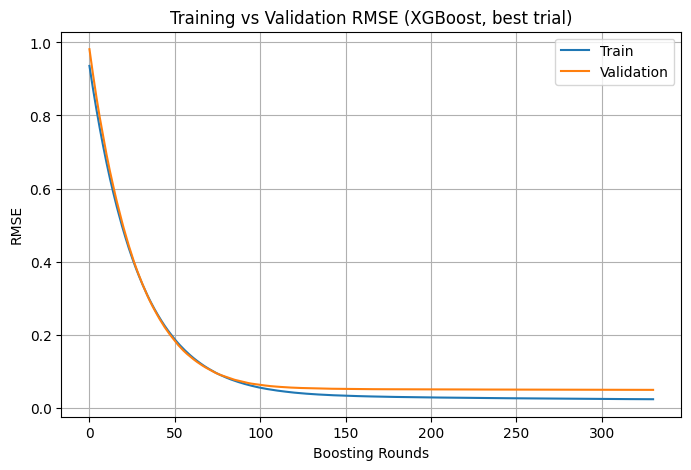

In [5]:
best_params = study.best_trial.params
best_model = XGBRegressor(**best_params)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False,
)

# --- Test evaluation ---
y_pred_test = best_model.predict(X_test)
y_pred_valid = best_model.predict(X_valid)
mse_test = mean_squared_error(y_test, y_pred_test)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
rmse_test = np.sqrt(mse_test)
rmse_valid = np.sqrt(mse_valid)
print("Valid RMSE:", rmse_valid)
print("Test RMSE:", rmse_test)
#print("Test R²:", r2_score(y_test, y_pred_test))

# eval history AFTER training
evals_result = best_model.evals_result()

# ------------------------
# Plot training vs validation RMSE
# ------------------------
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(epochs)

plt.figure(figsize=(8,5))
plt.plot(x_axis, evals_result['validation_0']['rmse'], label="Train")
plt.plot(x_axis, evals_result['validation_1']['rmse'], label="Validation")
#plt.plot(x_axis, evals_result['validation_1']['rmse'], label="Validation")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (XGBoost, best trial)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Hyperparameter importance ranking
vis.plot_param_importances(study)

In [7]:

# Slice plot (zoom in on individual parameters)
vis.plot_slice(study)

In [8]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

# Put into DataFrame for readability
feat_importance_df = pd.DataFrame({
    "Feature": X_train.columns[indices],
    "Importance": importances[indices]
})

save_path = os.path.join(save_dir, "feature_importance_top15.csv")
feat_importance_df.head(25).to_csv(save_path, index=True)
print(feat_importance_df.head(50))  # top 15 features

                    Feature  Importance
0                     Bng_h    0.375071
1                     Kau_h    0.237968
2                     Stg_h    0.180851
3                     Ruw_h    0.046763
4                Ruw_h_lag1    0.031732
5                     Fra_h    0.023809
6                     Klk_h    0.017294
7                     Hdb_h    0.012405
8                     Sie_h    0.003754
9                     Ahr_h    0.003268
10          sbs_temp_7_lag1    0.003056
11               Klk_h_lag1    0.002518
12                 Klk_diff    0.001903
13               Bng_h_lag1    0.001872
14          sbs_prep_4_lag1    0.001770
15          sbs_temp_9_lag1    0.001616
16                 Sie_diff    0.001330
17         sbs_temp_10_lag1    0.001128
18               Fra_h_lag1    0.001112
19          sbs_temp_7_lag5    0.001057
20            Ruw_diff_lag1    0.000985
21               Kau_h_lag3    0.000984
22  sbs_snow_oberrhein_lag3    0.000961
23          sbs_prep_3_lag1    0.000936


## Uncertainty Estimation

In [9]:
quantiles = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]
preds = {}

for q in quantiles:
    model = XGBRegressor(
        **best_params,
        objective="reg:quantileerror",
        quantile_alpha=q  # << required
    )
    model.fit(X_train, y_train)
    preds[q] = model.predict(X_test)

In [10]:
y

,Kln_h
2000-01-02,599.583333
2000-01-03,554.885417
2000-01-04,517.239583
2000-01-05,495.114583
2000-01-06,480.500000
...,...
2018-12-27,526.739583
2018-12-28,492.197917
2018-12-29,427.062500
2018-12-30,377.739583


In [11]:
y_test

,Kln_h
2017-12-31,1.587921
2018-01-01,2.113600
2018-01-02,2.550707
2018-01-03,2.915869
2018-01-04,3.308929
...,...
2018-12-26,1.629169
2018-12-27,1.364091
2018-12-28,0.864232
2018-12-29,0.485721


In [12]:
y_test

,Kln_h
2017-12-31,1.587921
2018-01-01,2.113600
2018-01-02,2.550707
2018-01-03,2.915869
2018-01-04,3.308929
...,...
2018-12-26,1.629169
2018-12-27,1.364091
2018-12-28,0.864232
2018-12-29,0.485721


In [13]:
y_date = y.loc[y_test.index]
#y_series = pd.Series(y_date, index=y_test.index)
y_series = y_date.squeeze()

In [14]:
y_series

2017-12-31    440.697917
2018-01-01    521.364583
2018-01-02    589.864583
2018-01-03    646.822917
2018-01-04    694.406250
                 ...    
2018-12-26    517.041667
2018-12-27    526.739583
2018-12-28    492.197917
2018-12-29    427.062500
2018-12-30    377.739583
Name: Kln_h, Length: 365, dtype: float64

In [15]:
# --- Build prediction bands ---
pred_05 = pd.Series(preds[0.05], index=y_test.index)
pred_10 = pd.Series(preds[0.1], index=y_test.index)
pred_20 = pd.Series(preds[0.2], index=y_test.index)
pred_40 = pd.Series(preds[0.4], index=y_test.index)
pred_60 = pd.Series(preds[0.6], index=y_test.index)
pred_80 = pd.Series(preds[0.8], index=y_test.index)
pred_90 = pd.Series(preds[0.9], index=y_test.index)
pred_95 = pd.Series(preds[0.95], index=y_test.index)

pred_05_h = scaler_y.inverse_transform(pred_05.to_numpy().reshape(-1, 1)).ravel()
pred_10_h = scaler_y.inverse_transform(pred_10.to_numpy().reshape(-1, 1)).ravel()
pred_20_h = scaler_y.inverse_transform(pred_20.to_numpy().reshape(-1, 1)).ravel()
pred_40_h = scaler_y.inverse_transform(pred_40.to_numpy().reshape(-1, 1)).ravel()
pred_60_h = scaler_y.inverse_transform(pred_60.to_numpy().reshape(-1, 1)).ravel()
pred_80_h = scaler_y.inverse_transform(pred_80.to_numpy().reshape(-1, 1)).ravel()
pred_90_h = scaler_y.inverse_transform(pred_90.to_numpy().reshape(-1, 1)).ravel()
pred_95_h = scaler_y.inverse_transform(pred_95.to_numpy().reshape(-1, 1)).ravel()

pred_mean = pd.Series(y_pred_test, index=y_test.index)
pred_mean_h = scaler_y.inverse_transform(pred_mean.to_numpy().reshape(-1, 1)).ravel()
pred_std_h  = pred_mean_h.std(axis=0)

#y_series = y.loc[y_test.index]
#y_series = pd.Series(y, index=y_test.index)
#y_series_h = y_series.reshape(-1, 1).ravel()

results = pd.DataFrame({
    "Actual": y_series,
    "Predicted": pred_mean_h,
    "std": pred_std_h,
    "10": pred_10_h,
    "20": pred_20_h,
    "40": pred_40_h,
    "60": pred_60_h,
    "80": pred_80_h,
    "90": pred_90_h
}, index=y_test.index)

print(results.head(10))
print("Observed range:", results["Actual"].min(), "-", results["Actual"].max())
print("Predicted range:", results["Predicted"].min(), "-", results["Predicted"].max())

                Actual   Predicted         std          10          20  \
2017-12-31  440.697917  550.227051  173.016891  417.132843  523.934753   
2018-01-01  521.364583  573.438538  173.016891  431.920166  560.553406   
2018-01-02  589.864583  636.980469  173.016891  431.632080  593.965576   
2018-01-03  646.822917  693.980774  173.016891  431.920166  597.448059   
2018-01-04  694.406250  753.733276  173.016891  434.466309  610.357605   
2018-01-05  745.625000  795.587402  173.016891  431.914398  609.395142   
2018-01-06  798.208333  839.649658  173.016891  432.324829  612.711609   
2018-01-07  847.114583  850.585815  173.016891  432.843506  616.860474   
2018-01-08  874.541667  828.605225  173.016891  431.920166  611.030273   
2018-01-09  861.177083  774.888977  173.016891  432.114960  609.781067   

                    40          60          80          90  
2017-12-31  534.841492  521.733521  523.685913  533.816589  
2018-01-01  589.243103  601.046143  589.809326  584.680298  
20

## Quick check if things look reasonable

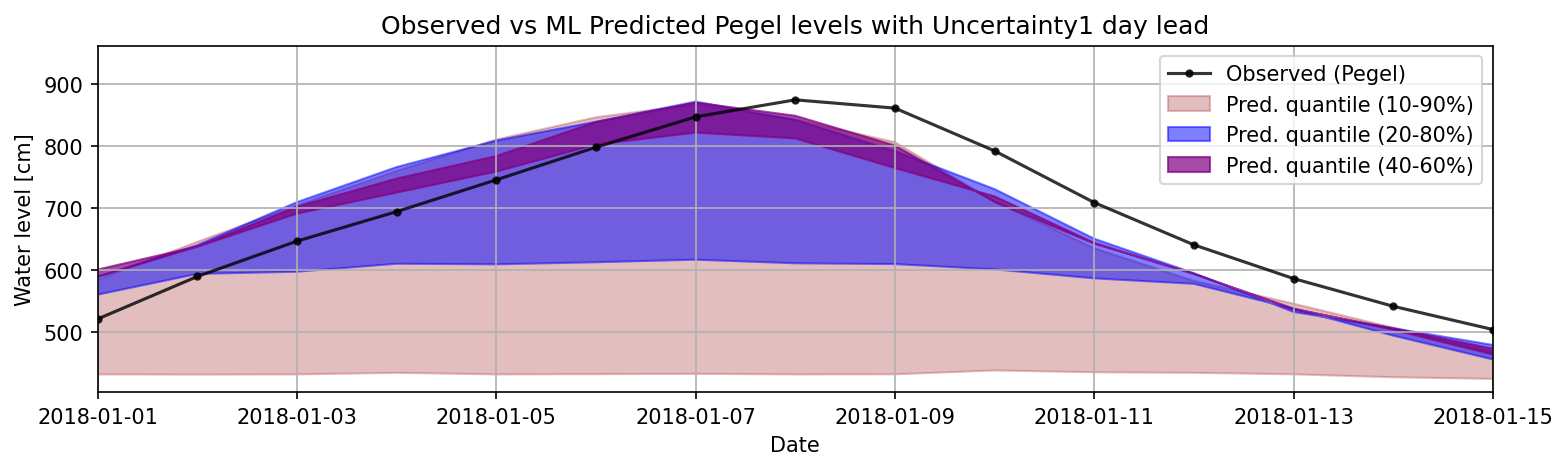

In [16]:
# --- Plot with uncertainty ---
fig, ax = plt.subplots(figsize=(12,3), dpi=150)

# Observed
ax.plot(results.index, results["Actual"], color="black", marker=".", label="Observed (Pegel)", alpha=0.8)

ax.fill_between(results.index, results["10"], results["90"], color="brown", alpha=0.3, label="Pred. quantile (10-90%)")
ax.fill_between(results.index, results["20"], results["80"], color="blue", alpha=0.5, label="Pred. quantile (20-80%)")
ax.fill_between(results.index, results["40"], results["60"], color="purple", alpha=0.7, label="Pred. quantile (40-60%)")
x0, x1 = pd.Timestamp("2018-1-01"), pd.Timestamp("2018-1-15")
ax.set_xlim(x0, x1)
mask = (results.index >= x0) & (results.index <= x1)
r_masked=results[mask]
ymin = r_masked["Actual"].min() - 0.2*r_masked["Actual"].min()
ymax = r_masked["Actual"].max() + 0.1*r_masked["Actual"].max()

ax.set_ylim(ymin, ymax)
ax.set_xlabel("Date")
ax.set_ylabel("Water level [cm]")
ax.set_title("Observed vs ML Predicted Pegel levels with Uncertainty"+str(lead_day)+" day lead")
ax.legend()
ax.grid(True)

plt.show()

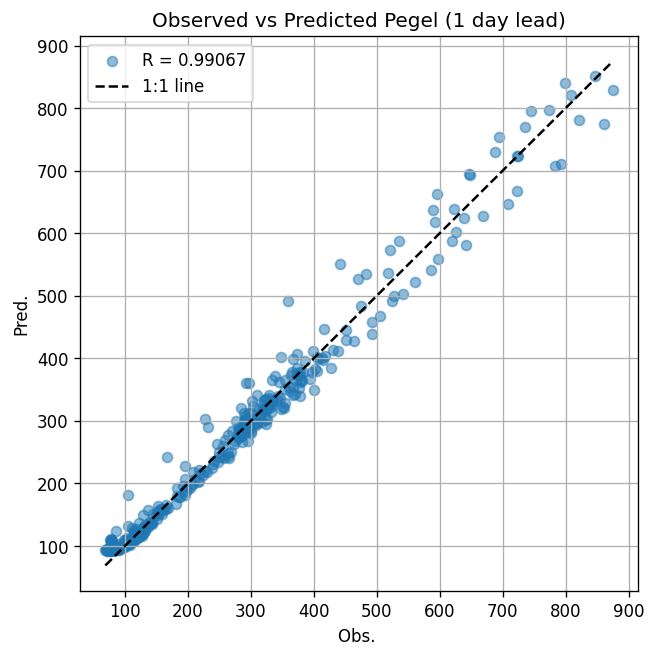

In [17]:
from scipy.stats import pearsonr
# Calculate correlation
corr, _ = pearsonr(results["Actual"], results["Predicted"])

plt.figure(figsize=(6,6), dpi=120)
plt.scatter(results["Actual"], results["Predicted"], alpha=0.5, label=f"R = {corr:.5f}")
plt.plot([results["Actual"].min(), results["Actual"].max()],
         [results["Actual"].min(), results["Actual"].max()],
         color="black", linestyle="--", label="1:1 line")

plt.xlabel("Obs. ")
plt.ylabel("Pred.")
plt.title("Observed vs Predicted Pegel ("+str(lead_day)+" day lead)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
results.to_csv("results_datasets/results_"+str(lead_day)+"d.csv", index=True)  # keep index if it's meaningful

In [19]:
results["band_width"] = results["90"] - results["10"]
corrs = X_ready.corrwith(results["band_width"])
save_path = os.path.join(save_dir, "correlationbandwidth_top15.csv")
corrs.head(15).to_csv(save_path, index=True)
print(corrs.sort_values(ascending=False).head(20))

Fra_h         0.754100
Ruw_h_lag1    0.745610
Ruw_h         0.737242
Hdb_h_lag1    0.736271
Fra_h_lag1    0.736120
Hdb_h_lag3    0.700229
Hdb_h         0.696718
Ruw_h_lag3    0.676385
Rhw_h_lag1    0.668632
Rhw_h         0.659768
Fra_h_lag3    0.639409
Klk_h_lag1    0.623378
Klk_h         0.616482
Rhw_h_lag3    0.596082
Klk_h_lag3    0.575602
Ruw_h_lag5    0.558826
Hdb_h_lag5    0.533149
Fra_h_lag5    0.516074
Sie_h_lag3    0.492510
Ahr_h_lag1    0.490098
dtype: float64


In [20]:
from datetime import datetime

now = datetime.now()
print(lead_day)
print(now.strftime("%H:%M"))

1
21:58
